# Build a P-value interpreter function with ChatGPT

In [4]:
def interpret_p_value(p_value, threshold=0.05):
    """
    Interpret the p-value in a statistical context against a specific threshold.

    Parameters:
    p_value (float): The p-value to interpret, expected to be in the range 0 to 1.
    threshold (float): The significance level threshold, default is 0.05.

    Returns:
    None: Prints the interpretation of the p-value.

    Raises:
    ValueError: If the p_value or threshold is not within the range [0, 1].

    Description:
    This function assesses the provided p-value against a given threshold:
    - p < threshold: Evidence suggests rejecting the null hypothesis.
    - p >= threshold: Not enough evidence to reject the null hypothesis.

    It's important to note that the interpretation of p-values is context-dependent
    and should be considered along with other factors in statistical analysis.
    """
    if not (0 <= p_value <= 1):
        raise ValueError("p_value must be between 0 and 1.")
    if not (0 <= threshold <= 1):
        raise ValueError("threshold must be between 0 and 1.")

    if p_value < threshold:
        print(f"p-value ({p_value}) is less than the threshold ({threshold}).")
        print("Evidence suggests rejecting the null hypothesis.")
    else:
        print(f"p-value ({p_value}) is greater than or equal to the threshold ({threshold}).")
        print("Not enough evidence to reject the null hypothesis.")

# Example usage
interpret_p_value(0.03, threshold=0.05)

p-value (0.03) is less than the threshold (0.05).
Evidence suggests rejecting the null hypothesis.


# Libraries and Data

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm

In [5]:
# Load the data
df = pd.read_csv("Krushing Kingdoms.csv")
df.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention
0,250642234,level_5,21,True,False
1,330729049,level_5,1,False,False
2,955307973,level_7,76,True,True
3,908651903,level_7,76,True,False
4,983320188,level_5,1,False,False


In [6]:
# df information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 50000 non-null  int64 
 1   team_level_access  50000 non-null  object
 2   minutes_played     50000 non-null  int64 
 3   day1_retention     50000 non-null  bool  
 4   day7_retention     50000 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.2+ MB


# Define Hypothesis

### Null Hypothesis: There is no difference in retention between the two groups

### Alternative Hypothesis: There is a difference in the mean retention between the 2 groups

# EDA

In [7]:
# 1. Descriptive Statistics
df.describe()

,id,minutes_played
count,5.000000e+04,50000.000000
mean,5.000967e+08,25.884040
std,2.894632e+08,51.130086
min,7.746000e+03,0.000000
25%,2.502251e+08,3.000000
50%,5.008450e+08,8.000000
75%,7.500803e+08,26.000000
max,9.999952e+08,1481.000000


The data has outliers and we should clean it

In [8]:
# 2. Group Comparisons
grouped = df.groupby('team_level_access').agg({'minutes_played': ['mean', 'median'],
                                               'day1_retention': 'mean',
                                               'day7_retention': 'mean'})
print(grouped)

                  minutes_played        day1_retention day7_retention
                            mean median           mean           mean
team_level_access                                                    
level_5                26.038934    9.0       0.448304       0.189176
level_7                25.732092    8.0       0.441561       0.181537


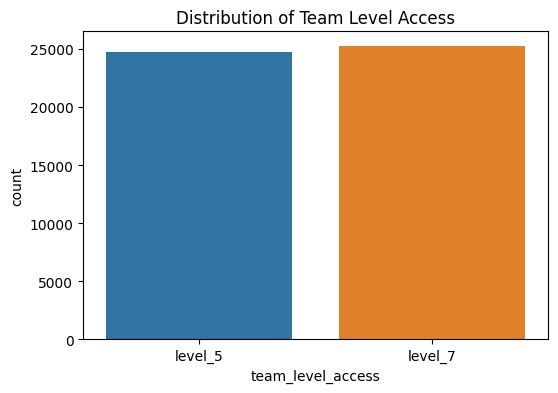

In [9]:
# Distribution of team level access
plt.figure(figsize=(6, 4))
sns.countplot(x='team_level_access', data=df)
plt.title('Distribution of Team Level Access')
plt.show()

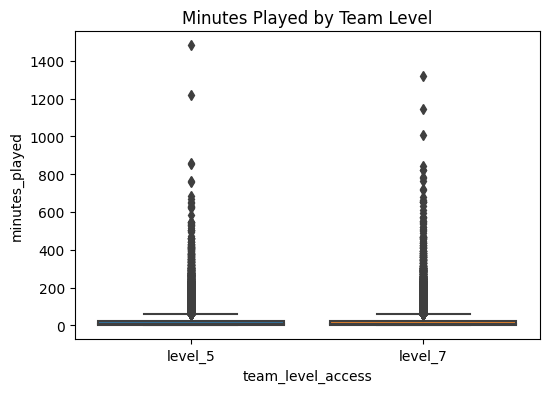

In [10]:
# Boxplot of minutes played by team level
plt.figure(figsize=(6, 4))
sns.boxplot(x='team_level_access', y='minutes_played', data=df)
plt.title('Minutes Played by Team Level')
plt.show()

#This shows that there are tons of outliers. Need to clean

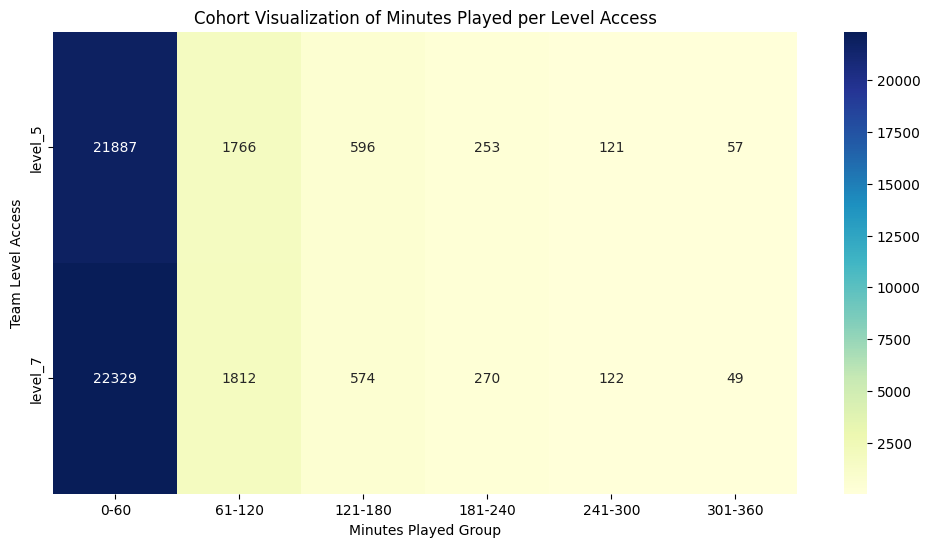

In [11]:
# Binning the minutes played into categories
bins = [0, 60, 120, 180, 240, 300, 360]
labels = ['0-60', '61-120', '121-180', '181-240', '241-300', '301-360']
df['minutes_played_group'] = pd.cut(df['minutes_played'],
                                    bins=bins, labels=labels, right=False)

# Creating a pivot table
cohort_data = df.pivot_table(index='team_level_access',
                             columns='minutes_played_group',
                             aggfunc='size', fill_value=0)

# Plotting the cohort data
plt.figure(figsize=(12, 6))
sns.heatmap(cohort_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Cohort Visualization of Minutes Played per Level Access')
plt.xlabel('Minutes Played Group')
plt.ylabel('Team Level Access')
plt.show()

# Outliers

<Axes: >

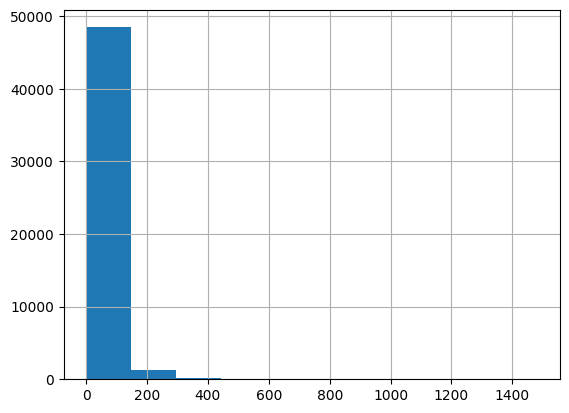

In [12]:
# Look at the minutes played
df.minutes_played.hist()

In [13]:
# Summary statistics
df.describe()

,id,minutes_played
count,5.000000e+04,50000.000000
mean,5.000967e+08,25.884040
std,2.894632e+08,51.130086
min,7.746000e+03,0.000000
25%,2.502251e+08,3.000000
50%,5.008450e+08,8.000000
75%,7.500803e+08,26.000000
max,9.999952e+08,1481.000000


## Calculating IQR 

In [7]:
# Calculating IQR for minutes_played
Q1 = df['minutes_played'].quantile(0.25)
Q3 = df['minutes_played'].quantile(0.75)
IQR = Q3 - Q1

print(Q1, Q3, IQR)

3.0 26.0 23.0


In [8]:
# Defining outliers for minutes_played
outliers = ((df['minutes_played'] < (Q1 - 1.5 * IQR)) | (df['minutes_played'] > (Q3 + 1.5 * IQR)))

# Removing outliers based on minutes_played
df_cleaned = df[~outliers]

df_cleaned.describe()  # Display summary statistics without outliers

,id,minutes_played
count,4.431900e+04,44319.000000
mean,4.993766e+08,12.208240
std,2.893929e+08,13.750095
min,7.746000e+03,0.000000
25%,2.491266e+08,2.000000
50%,5.000784e+08,7.000000
75%,7.496319e+08,17.000000
max,9.999952e+08,60.000000


# Randomization

### Simple Randomization

In [12]:
# Let's say '1' is for group A and '0' is for group B
number_of_users = 500
group_assignment = np.random.choice([0,1],
                                    size =
                                    number_of_users, p = [0.5, 0.5])

# Count the number of elements per group
np.unique(group_assignment, return_counts = True)

(array([0, 1]), array([261, 239]))

### Block Randomization

In [16]:
from sklearn.utils import shuffle

In [17]:
# Assuming that "block_size" is how many users we want in each block
block_size = 50
blocks = [0] * block_size + [1] * block_size
group_assignment = shuffle(blocks * int(number_of_users / (2 * block_size)))

# Count the number of elements per group
np.unique(group_assignment, return_counts = True)

(array([0, 1]), array([250, 250]))

### Stratified Randomization

In [17]:
# Build a copy from our df
df_stratified = df.copy()

In [18]:
# Create a age group variable
age_groups = ['18-25', '26-34', '36-45', '46-55']
df_stratified['age_group'] = np.random.choice(age_groups,
                                              size = len(df_stratified),
                                              replace = True)
df_stratified.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention,minutes_played_group,age_group
0,250642234,level_5,21,True,False,0-60,36-45
1,330729049,level_5,1,False,False,0-60,36-45
2,955307973,level_7,76,True,True,61-120,46-55
3,908651903,level_7,76,True,False,61-120,18-25
4,983320188,level_5,1,False,False,0-60,46-55


In [19]:
# Build a function for stratified randomization
def stratified_randomization(group):
  # Assign 'A' or 'B' with equal probability
  group['group_assignment'] = np.random.choice(['A', 'B'],
                                              size = len(group),
                                              p = [0.5, 0.5])
  return group

In [20]:
# Apply the function
df_stratified = df_stratified.groupby(
    'age_group', group_keys = False).apply(stratified_randomization)
df_stratified.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention,minutes_played_group,age_group,group_assignment
0,250642234,level_5,21,True,False,0-60,36-45,B
1,330729049,level_5,1,False,False,0-60,36-45,A
2,955307973,level_7,76,True,True,61-120,46-55,B
3,908651903,level_7,76,True,False,61-120,18-25,B
4,983320188,level_5,1,False,False,0-60,46-55,B


In [21]:
# Check the results
df_stratified.groupby(['age_group', 'group_assignment']).size()

age_group  group_assignment
18-25      A                   6321
           B                   6165
26-34      A                   6240
           B                   6161
36-45      A                   6335
           B                   6283
46-55      A                   6302
           B                   6193
dtype: int64

### Cluster Randomization / Geotest

In [22]:
# Build a copy from our df
clustering_df = df.copy()

In [23]:
# Create a city variable
cities = ['New York', 'Los Angeles', 'Chicago', 'Houston']
clustering_df['city'] = np.random.choice(cities,
                                              size = len(clustering_df),
                                              replace = True)
clustering_df.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention,minutes_played_group,city
0,250642234,level_5,21,True,False,0-60,New York
1,330729049,level_5,1,False,False,0-60,Los Angeles
2,955307973,level_7,76,True,True,61-120,New York
3,908651903,level_7,76,True,False,61-120,Los Angeles
4,983320188,level_5,1,False,False,0-60,Los Angeles


In [24]:
# create a list with two cities in one cluster and 2 in anoter
assigned_clusters = [0, 0 ,1, 1]
np.random.shuffle(assigned_clusters)

In [25]:
# Create a dictionary to map out the city and the assigned cluster
city_to_group = dict(zip(cities, assigned_clusters))
city_to_group

{'New York': 0, 'Los Angeles': 1, 'Chicago': 1, 'Houston': 0}

In [26]:
# Create the cluster group variable
clustering_df['cluster_group'] = clustering_df['city'].map(city_to_group)
clustering_df.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention,minutes_played_group,city,cluster_group
0,250642234,level_5,21,True,False,0-60,New York,0
1,330729049,level_5,1,False,False,0-60,Los Angeles,1
2,955307973,level_7,76,True,True,61-120,New York,0
3,908651903,level_7,76,True,False,61-120,Los Angeles,1
4,983320188,level_5,1,False,False,0-60,Los Angeles,1


In [27]:
# Check the results
clustering_df.groupby(['city', 'cluster_group']).size()

city         cluster_group
Chicago      1                12501
Houston      0                12633
Los Angeles  1                12499
New York     0                12367
dtype: int64

# Sample Size Calculation

In [26]:
# Settings
alpha = 0.05 #meaning the confidence level is 95%
power = 0.8
# Minimum Detectable effect. The smaller it is the bigger the sample size.
mde = 0.05

### Sample Size Calculation for Proportions

In [27]:
# Computing the Baseline %
baseline_retention = df_cleaned[
    df_cleaned['team_level_access'] == 'level_5']['day7_retention'].mean()
print(f"The Baseline Retention is {baseline_retention}")

The Baseline Retention is 0.11644772851669404


In [28]:
# Calculate the effect size
effect_size = sm.stats.proportion_effectsize(baseline_retention,
                                             baseline_retention + mde)

In [29]:
# Initiate the power analysis
power_analysis = sm.stats.NormalIndPower()
sample_size_discrete = power_analysis.solve_power(effect_size = effect_size,
                                                  power = power,
                                                  alpha = alpha,
                                                  ratio = 1.0)
print(f"The Sample Size per group is {round(sample_size_discrete)}")

The Sample Size per group is 757


### Sample size for continuous outcomes

In [30]:
# Computing the Baseline minutes
baseline_minutes = df_cleaned[
    df_cleaned['team_level_access'] == 'level_5']['minutes_played'].mean()
print(f"The Baseline minutes is {baseline_minutes}")

# Baseline variability
baseline_sigma = df_cleaned[
    df_cleaned['team_level_access'] == 'level_5']['minutes_played'].std()
print(f"The Baseline Variability is {baseline_sigma}")

The Baseline minutes is 12.262953840540048
The Baseline Variability is 13.6339887214411


In [31]:
# Compute the effect size
effect_size = mde * baseline_minutes / baseline_sigma
print(f"The effect size is {effect_size}")

The effect size is 0.0449719964241098


In [32]:
# Alpha and Beta
Zalpha = stats.norm.ppf(1-alpha / 2)
Zbeta = stats.norm.ppf(power)

In [33]:
# Calculate the Sample size
sample_size_continuous = (
    (Zalpha + Zbeta)**2 * (baseline_sigma**2)) / (effect_size **2)
print(f"The Sample Size per group is {sample_size_continuous:.0f}")

The Sample Size per group is 721388


### What if we don't clean the outliers?

In [34]:
# Computing the Baseline minutes
baseline_minutes = df[
    df['team_level_access'] == 'level_5']['minutes_played'].mean()
print(f"The Baseline minutes is {baseline_minutes}")

# Baseline variability
baseline_sigma = df[
    df['team_level_access'] == 'level_5']['minutes_played'].std()
print(f"The Baseline Variability is {baseline_sigma}")

The Baseline minutes is 26.038933764135702
The Baseline Variability is 50.95305446540207


In [35]:
# Compute the effect size
effect_size = mde * baseline_minutes / baseline_sigma
print(f"The effect size is {effect_size}")

The effect size is 0.025551886964712344


In [36]:
# Alpha and Beta
Zalpha = stats.norm.ppf(1-alpha / 2)
Zbeta = stats.norm.ppf(power)

In [37]:
# Calculate the Sample size
sample_size_continuous = (
    (Zalpha + Zbeta)**2 * (baseline_sigma**2)) / (effect_size **2)
print(f"The Sample Size per group is {sample_size_continuous:.0f}")

The Sample Size per group is 31210604


Pro Tip 1 :Always clean outliers for A/B Testing

Pro Tip 2: Choose the proportion as the main outcome KPI and the continuous as secondary

# Post Analysis

### Post Analysis for Retention with Calculated Sample Size

In [38]:
# Sampling
N = int(sample_size_discrete)
sample5 = df_cleaned[
    df_cleaned['team_level_access'] == 'level_5'].sample(n = N,
                                                         random_state = 1502)

sample7 = df_cleaned[
    df_cleaned['team_level_access'] == 'level_7'].sample(n = N,
                                                         random_state = 1502)

In [39]:
# Calculating the number of successes and trials
n_5= sample5['day7_retention'].count()
n_7= sample7['day7_retention'].count()
successes_5= sample5['day7_retention'].sum()
successes_7= sample7['day7_retention'].sum()

In [40]:
# Compute the level access retention rate
rr_5 = successes_5 / n_5
rr_7 = successes_7 / n_7
print(f"The Retention Rate for level 5 is {rr_5}")
print(f"The Retention Rate for level 7 is {rr_7}")

The Retention Rate for level 5 is 0.11624834874504623
The Retention Rate for level 7 is 0.10303830911492734


In [77]:
# Proportions Test
import statsmodels.stats.proportion as proportion
z_value, p_value = proportion.proportions_ztest([successes_5, successes_7], [n_5, n_7],
                                                alternative = "two-sided")
interpret_p_value(p_value, threshold=0.05)

p-value (0.4107621742385773) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


If we changed the MDE from 5% to 1% then the p-value would be below the threshold and you would have evidence to reject the null. NOTE: Not ideal to go back and change the sample size so freely.

### Post Analysis for Retention with the Complete Data

In [80]:
# Sampling
N = int(sample_size_discrete)
sample5 = df_cleaned[df_cleaned['team_level_access'] == 'level_5']

sample7 = df_cleaned[df_cleaned['team_level_access'] == 'level_7']

In [81]:
# Calculating the number of successes and trials
n_5= sample5['day7_retention'].count()
n_7= sample7['day7_retention'].count()
successes_5= sample5['day7_retention'].sum()
successes_7= sample7['day7_retention'].sum()

In [82]:
# Compute the level access retention rate
rr_5 = successes_5 / n_5
rr_7 = successes_7 / n_7
print(f"The Retention Rate for level 5 is {rr_5}")
print(f"The Retention Rate for level 7 is {rr_7}")

The Retention Rate for level 5 is 0.11644772851669404
The Retention Rate for level 7 is 0.10877427997320831


variance_proportions = proportion_mean * (1 - proportion_mean)

In [83]:
# Proportions Test
import statsmodels.stats.proportion as proportion
z_value, p_value = proportion.proportions_ztest([successes_5, successes_7], [n_5, n_7],
                                                alternative = "two-sided")
interpret_p_value(p_value, threshold=0.05)

p-value (0.010607771169938515) is less than the threshold (0.05).
Evidence suggests rejecting the null hypothesis.


### Post Analysis for Minutes Played

In [41]:
# Prepare the inputs
minutes5 = df_cleaned[df_cleaned['team_level_access'] == 'level_5']['minutes_played']

minutes7 = df_cleaned[df_cleaned['team_level_access'] == 'level_7']['minutes_played']

In [42]:
# 2 sample T-test
t_statistic, p_value = stats.ttest_ind(minutes5,
                                       minutes7,
                                       alternative = 'two-sided')
interpret_p_value(p_value, threshold=0.05)

p-value (0.40720311949312926) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


### Calculating MDE 

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

def calculate_mde(baseline_rate, sample_size, alpha=0.05, power=0.80):
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(power)
    
    mde = (z_alpha + z_beta) * np.sqrt(2 * baseline_rate * (1 - baseline_rate) / sample_size)
    return mde

# Create a DataFrame with different scenarios
scenarios = pd.DataFrame({
    'baseline_rate': [0.10, 0.15, 0.20],
    'sample_size': [5000, 10000, 20000]
})

# Calculate MDE for each scenario
scenarios['mde'] = scenarios.apply(lambda row: calculate_mde(row['baseline_rate'], row['sample_size']), axis=1)

# Calculate relative MDE
scenarios['relative_mde'] = scenarios['mde'] / scenarios['baseline_rate']

# Format results
scenarios['mde'] = scenarios['mde'].map('{:.4f}'.format)
scenarios['relative_mde'] = scenarios['relative_mde'].map('{:.2%}'.format)

print(scenarios)

# Example of using the function directly
baseline_rate = 0.10
sample_size = 10000
mde = calculate_mde(baseline_rate, sample_size)
print(f"\nFor a baseline rate of {baseline_rate:.2%} and sample size of {sample_size}:")
print(f"Minimum Detectable Effect: {mde:.4f}")
print(f"Relative MDE: {mde/baseline_rate:.2%}")